In [3]:
!pip install sagemaker==2.214.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.199.0
    Uninstalling sagemaker-2.199.0:
      Successfully uninstalled sagemaker-2.199.0

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [10]:
!apt-get update -y
!apt-get install -y libgl1-mesa-glx

Get:1 http://security.debian.org/debian-security bullseye-security InRelease [48.4 kB]
Get:2 http://deb.debian.org/debian bullseye InRelease [116 kB]
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Get:4 http://security.debian.org/debian-security bullseye-security/main amd64 Packages [271 kB]
Get:5 http://deb.debian.org/debian bullseye/main amd64 Packages [8068 kB]
Get:6 http://deb.debian.org/debian bullseye-updates/main amd64 Packages [18.8 kB]
Fetched 8565 kB in 2s (4163 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libelf1 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0 libglx-mesa0
  libglx0 libllvm11 libpciaccess0 libsensors-config libsensors5 libvulkan1
  libwayland-client0 libx11-6 libx11-xcb1 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0

In [4]:
import sagemaker
import boto3
from sagemaker.huggingface import HuggingFaceModel

try:
	role = sagemaker.get_execution_role()
except ValueError:
	iam = boto3.client('iam')
	role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

# Hub Model configuration. https://huggingface.co/models
hub = {
	'HF_MODEL_ID':'mattmdjaga/segformer_b2_clothes',
	'HF_TASK':'image-segmentation'
}

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
	transformers_version='4.37.0',
	pytorch_version='2.1.0',
	py_version='py310',
	env=hub,
	role=role, 
)

# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
	initial_instance_count=1, # number of instances
	instance_type='ml.m5.xlarge' # ec2 instance type
)



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
------!

In [6]:
predictor

/tmp/ipykernel_1076/2291145047.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(pred_decoded_byte, np.uint8)


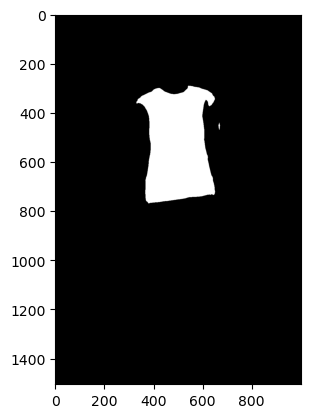

/tmp/ipykernel_1076/2291145047.py:26: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(pred_decoded_byte, np.uint8)


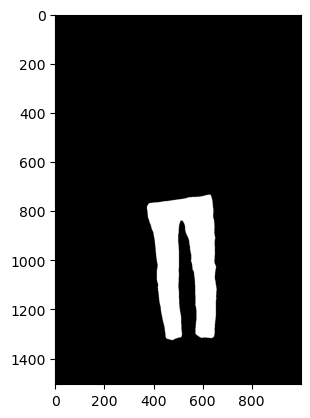

In [11]:
from sagemaker.serializers import DataSerializer
import json
import base64
import matplotlib.pyplot as plt 
import numpy as np  
import cv2

predictor.serializer = DataSerializer(content_type='image/x-image')

# Make sure the input file "cats.jpg" exists
with open("idol.jpeg", "rb") as f:
	data = f.read()
result = predictor.predict(data)

for i in result:
    if i['label'] == 'Upper-clothes':
        pred_decoded_byte = base64.decodebytes(bytes(i['mask'], encoding="utf-8"))
        nparr = np.fromstring(pred_decoded_byte, np.uint8)
        img_np = cv2.imdecode(nparr, cv2.IMREAD_COLOR) # cv2.IMREAD_COLOR in OpenCV 3.1

        cv2.imwrite('test-result.png', img_np)
        plt.imshow(img_np)
        plt.show()
    elif i['label'] == 'Pants':
        pred_decoded_byte = base64.decodebytes(bytes(i['mask'], encoding="utf-8"))
        nparr = np.fromstring(pred_decoded_byte, np.uint8)
        img_np2 = cv2.imdecode(nparr, cv2.IMREAD_COLOR) # cv2.IMREAD_COLOR in OpenCV 3.1

        cv2.imwrite('test2-result.png', img_np2)
        plt.imshow(img_np2)
        plt.show()

In [1]:
import boto3

In [2]:
runtime = boto3.client('sagemaker-runtime')

In [3]:
with open("input/idol.jpeg", "rb") as f:
	data = f.read()

In [18]:
response = runtime.invoke_endpoint(
    EndpointName='huggingface-pytorch-inference-2024-04-09-07-18-10-488',
    ContentType='image/x-image',
    Body=data
)

In [16]:
print(response['Body'].read().decode('utf-8'))
#import json
#result = json.load(response['Body'].read())

[{"score":null,"label":"Background","mask":"iVBORw0KGgoAAAANSUhEUgAAA+gAAAXhCAAAAAAsF+/KAAAgWUlEQVR4nO3d7ZbbNpqFUWqW7/+WNT/sju2yqkok8fECZ++1ZjpJpxMKwkOAFFX1eB7A7v5v9gEA/QkdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAvyYfQBc9Pjw588pR8EiHubHkj5m/j/eTl4S+oo+y/w4Dq3zitDX82Xmx3FonX8IfTXfZ34ch9b5m9BX8mbkf/D2chyH0Ks7n/a/vMUIvbQWmR/HoXWEXlizzo/jEHs2T8bV1bbz49H4n8dKPBkX5GFZj2VFL6vLAmxVDyX0MDbwmYQeR+mJhF6VHmlI6HmcQgIJvaieNSo9j9Br6tui0uMIvaTeJSo9jdAr6t+hT9nCCL2gIREqPYrQyxm12Co9idCr0R8dCD2XU0oQoRczsj6l5xA6BBB6LWMXWUt6DKFHU3oKoZciPPoQejZPyIUQeiUzqlN6BKEXMqc5pScQOkoPIPQ6BEc3Qi9jXufOMPsTehVqoyOhF6FzehJ6DXM7d5bZntBLUBp9CR0CCB0CCL2C6Tv36QdAZ0KHAEKHAEIvwMaZ3oTOcTjXbE/oEEDo81lN6U7oHMfhbLM7oUMAoU9nLaU/oUMAofOTjcXWhA4BhD6blZQB

In [19]:
result = response['Body'].read().decode('utf-8')

In [23]:
result = json.loads(result)
print(result)

[{'score': None, 'label': 'Background', 'mask': 'iVBORw0KGgoAAAANSUhEUgAAA+gAAAXhCAAAAAAsF+/KAAAgWUlEQVR4nO3d7ZbbNpqFUWqW7/+WNT/sju2yqkok8fECZ++1ZjpJpxMKwkOAFFX1eB7A7v5v9gEA/QkdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAggdAvyYfQBc9Pjw588pR8EiHubHkj5m/j/eTl4S+oo+y/w4Dq3zitDX82Xmx3FonX8IfTXfZ34ch9b5m9BX8mbkf/D2chyH0Ks7n/a/vMUIvbQWmR/HoXWEXlizzo/jEHs2T8bV1bbz49H4n8dKPBkX5GFZj2VFL6vLAmxVDyX0MDbwmYQeR+mJhF6VHmlI6HmcQgIJvaieNSo9j9Br6tui0uMIvaTeJSo9jdAr6t+hT9nCCL2gIREqPYrQyxm12Co9idCr0R8dCD2XU0oQoRczsj6l5xA6BBB6LWMXWUt6DKFHU3oKoZciPPoQejZPyIUQeiUzqlN6BKEXMqc5pScQOkoPIPQ6BEc3Qi9jXufOMPsTehVqoyOhF6FzehJ6DXM7d5bZntBLUBp9CR0CCB0CCL2C6Tv36QdAZ0KHAEKHAEIvwMaZ3oTOcTjXbE/oEEDo81lN6U7oHMfhbLM7oUMAoU9nLaU/oUMAofOTjcXWhA4BhD6

/var/folders/5t/1rxwb4lx7219l4yd8mp550gw0000gr/T/ipykernel_7680/1216478357.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(pred_decoded_byte, np.uint8)


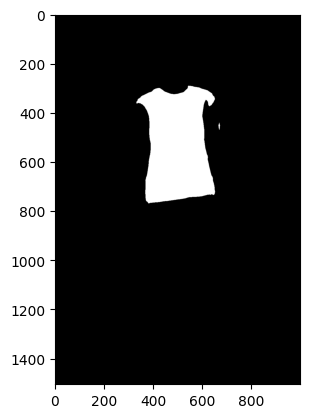

/var/folders/5t/1rxwb4lx7219l4yd8mp550gw0000gr/T/ipykernel_7680/1216478357.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(pred_decoded_byte, np.uint8)


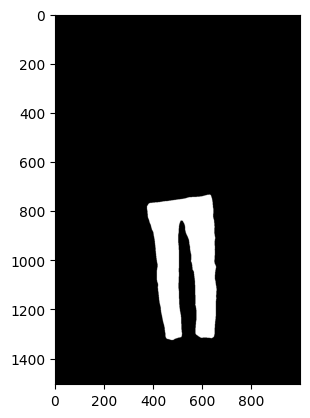

In [27]:
import matplotlib.pyplot as plt 
import base64
import numpy as np
import cv2
for i in result:
    if i['label'] == 'Upper-clothes':
        pred_decoded_byte = base64.decodebytes(bytes(i['mask'], encoding="utf-8"))
        nparr = np.fromstring(pred_decoded_byte, np.uint8)
        img_np = cv2.imdecode(nparr, cv2.IMREAD_COLOR) # cv2.IMREAD_COLOR in OpenCV 3.1

        #cv2.imwrite('test-result.png', img_np)
        plt.imshow(img_np)
        plt.show()
    elif i['label'] == 'Pants':
        pred_decoded_byte = base64.decodebytes(bytes(i['mask'], encoding="utf-8"))
        nparr = np.fromstring(pred_decoded_byte, np.uint8)
        img_np2 = cv2.imdecode(nparr, cv2.IMREAD_COLOR) # cv2.IMREAD_COLOR in OpenCV 3.1

        #cv2.imwrite('test2-result.png', img_np2)
        plt.imshow(img_np2)
        plt.show()